# Attention tokens

While exploring some other behaviour I noticed that different heads consistently represent inputs using a small set of tokens, where tokens are generated by directly projecting the components of attention heads (i.e. q, k, v and q*k) onto the residual stream and unembeding the result. Each head learns a mostly distinct set of tokens, but there are a small number of tokens are that are common and shared across all heads. These shared tokens make up the bulk of the outputs, for any input, pointing to position encodings being a primary driver of this behaviour.

To illustrate this - if you take the union of the attention tokens generated by each head component across a set of inputs from two arbitrary datasets (e.g. imdb reviews vs random tokens) you get the same result.

> {11, 12, 13, 198, 257, 262, 284, 286, 287, 290, 357, 366, 393, 705}

Or as strings:

> {' a', ' and', " '", ' (', ' the', '\n', ' or', ',', '-', '.', ' "', ' to', ' of', ' in'}

This scales with input length, but doesn't grow in token index order. The inital set is always {11, 262}.

Or if you take the q*k token sets for each of these datasets you see almost perfect coverage - 481 shared vs 490 total.

One way to think about this is each head using these shared tokens and it's unique attention tokens to chunk inputs in ways specific to that head. Some heads compress inputs into a small number attention tokens - as few as 3-4 for 16 token inputs. Others expand and others linearly track or double with input. My intuition is that this represents how heads structurally decompose inputs to represent meaning for their specific tasks and so provides a means for classifying heads.

Macro patterns across heads also emerge - particularly when considering the element-wise product of q and k. The plot on the left shows a t-SNE plot for the embeddings of the element-wise attention tokens - colors representing layers. The plot on the right shows how attention tokens are shared between all pairs of attention heads.

<div style="display: flex; justify-content: center;">
    <img src="./images/imdb-tsne.png" alt="Image 1" style="width: 45%; margin-right: 10px;">
    <img src="./images/shared-token_imdb.png" alt="Image 2" style="width: 45%;">
</div>

In [1]:
import torch
from transformer_lens import HookedTransformer 
import matplotlib.pyplot as plt
import pandas as pd

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


The plot below allows you to explore how attention tokens are generated. Note, the colourscale is based on the order in which the attention tokens are discovered during generation meaning brighter colours represent tokens generated later in the process. This means that colours don't represent absolute token values and instead more of a relative position within the generation.

In [2]:
prompt = "The next sentence is false. The previous sentence is true."
cache = run_prompts(model, prompt)

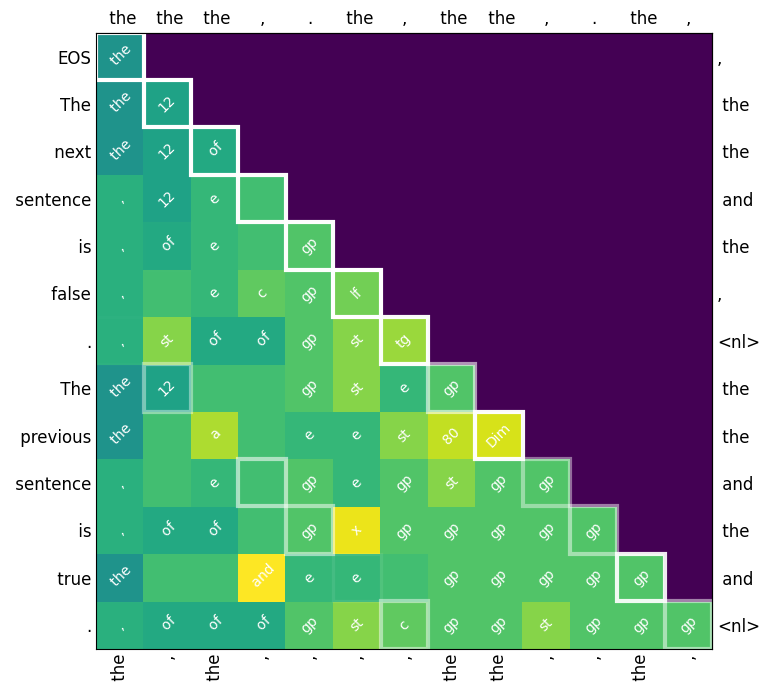

In [3]:
l, h = 0, 1
attn_data = calculate_attns(cache, l, h)
plot = plot_attn(model, attn_data)

Zooming out a bit we can look at the plots for the heads in the first layer.

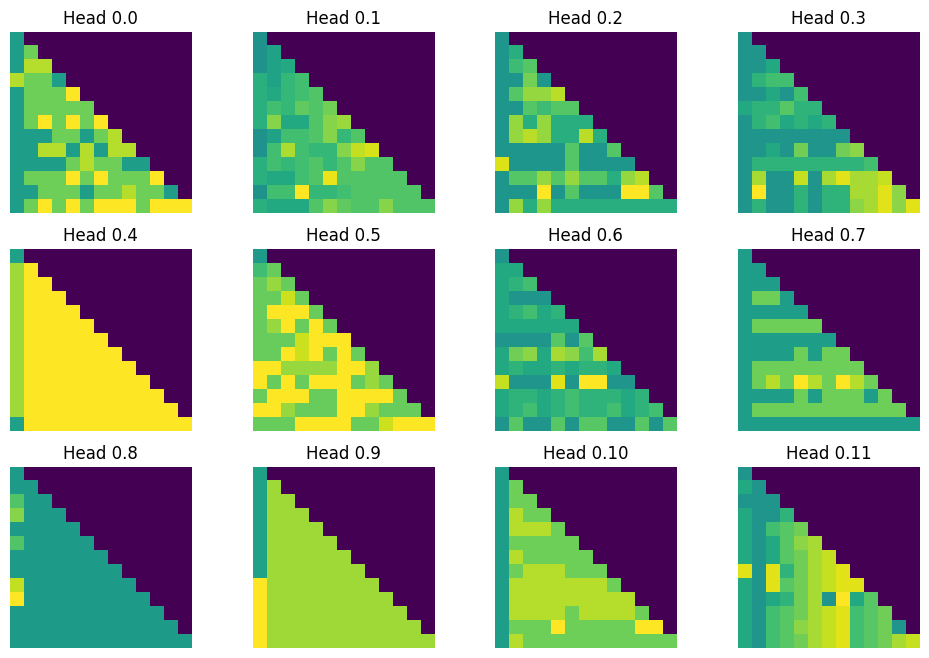

In [4]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    attn_data = calculate_attns(cache, l, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{i}")

To get a sense of how attention tokens are generated I want to test over a reasonably large and varied inputs. For the time being I'm using the imdb dataset because it contains a wide variety of natural language from multiple authors and is relatively small.

The code below extracts 3 random prompts from the dataset and uses them as the input into the model. We then use the cached activations to generate a dataset of attention tokens for each component across each head. The length of each prompt is capped at 16 tokens.

In [5]:
from datasets import load_dataset

dataset = load_dataset("imdb")
prompts = random.choices(dataset["train"]["text"], k=4)
prompts = model.to_string(model.to_tokens(prompts)[:, :30])
filename = f'../data/imdb.csv'
df = load_or_create_data(filename, model, *prompts)
df

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
553531,3,26,30,11.0,11.0,9005.0,0.041872,28213.0,23712.0,16100.0,42637.0,2887.0
553532,3,27,30,11.0,11.0,9005.0,0.003924,43617.0,47992.0,16100.0,42637.0,2887.0
553533,3,28,30,11.0,11.0,9005.0,0.014078,48527.0,23712.0,16100.0,42637.0,2887.0
553534,3,29,30,11.0,11.0,9005.0,0.019455,16100.0,23712.0,16100.0,42637.0,2887.0


Plotting the heads from the first layer produces results that are broadly consistent with the plots above. For example, heads 0.4, 0.8, and 0.9 have a lower number of unique tokens compared to the other heads. 0.7 tends to represent inputs as simple horizontal patterns and 0.11 tends to represent inputs as more complex vertical patterns.

Each time the code runs it selects a random input to plot. The sample size is small, but you can see clear patterns between different heads. Below I use some random examples to explore this further.

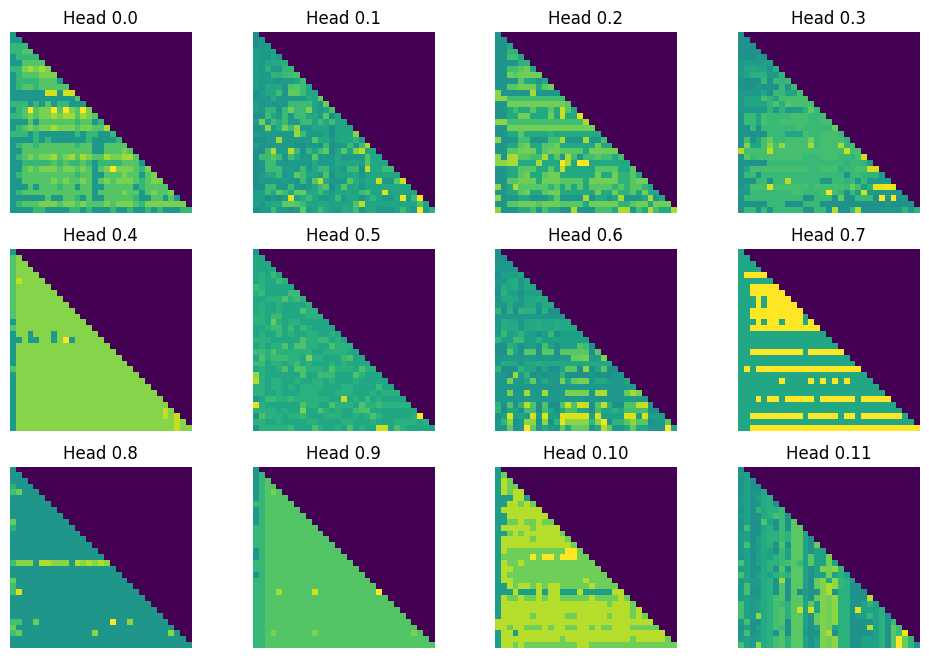

In [6]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    l, h = get_head_index(i)
    attn_data = df_to_tensor(df, l, h)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{h}")

While it's interesting to look at the patterns that emerge in the token plots, and I think it can be useful for interpreting head behaviour (see below), it doesn't help to understand any macro patterns that may exist across the model heads.

Calculating fequencies of each token shows a dramatic compaction down to ~1200 tokens for the element-wise product and ~10000 for the Q and K components and ~25000 for V. These numbers seem relatively invariant to actual token input and length - see random token experiments below for more details.

In [7]:
token_counts = calculate_token_frequencies(model, df)
token_counts

,head_index,token,qk,dp,q,k,v,qk_rank,dp_rank,q_rank,k_rank,v_rank,token str
0,0.0,11,157.0,12.0,1006.0,366.0,293.0,3.0,5.0,1.0,3.0,3.0,","
1,0.0,198,16.0,0.0,43.0,0.0,92.0,8.0,6.0,3.0,12.0,4.0,\n
2,0.0,262,0.0,0.0,935.0,486.0,665.0,10.0,6.0,2.0,2.0,2.0,the
3,0.0,287,0.0,0.0,0.0,734.0,0.0,10.0,6.0,4.0,1.0,6.0,in
4,0.0,290,8.0,866.0,0.0,22.0,861.0,9.0,1.0,4.0,6.0,1.0,and
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29321,143.0,49507,0.0,0.0,0.0,1.0,0.0,8.0,40.0,29.0,32.0,17.0,curls
29322,143.0,50006,0.0,0.0,0.0,1.0,0.0,8.0,40.0,29.0,32.0,17.0,ilage
29323,143.0,50026,0.0,0.0,0.0,4.0,0.0,8.0,40.0,29.0,29.0,17.0,Ulster
29324,143.0,50144,0.0,0.0,0.0,1.0,0.0,8.0,40.0,29.0,32.0,17.0,Assignment


The plots below show how the token frequency against the rank within that head. Colours represent head index.

<Axes: >

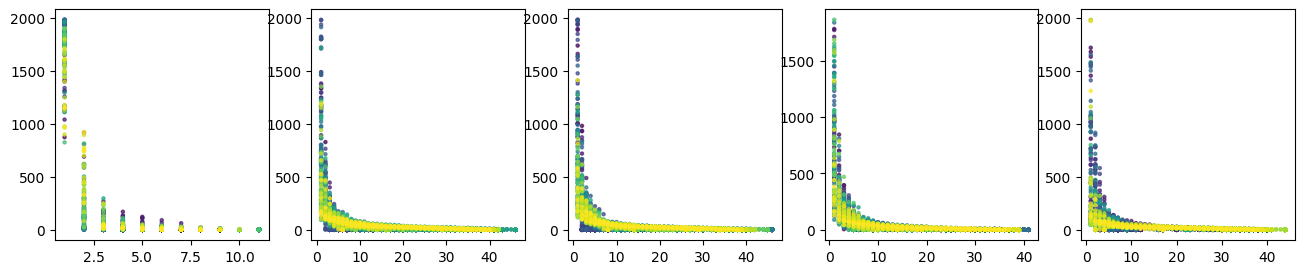

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
plot_scatter(token_counts['qk_rank'], token_counts['qk'], token_counts['head_index'], ax=axs[0])
plot_scatter(token_counts['dp_rank'], token_counts['dp'], token_counts['head_index'], ax=axs[1])
plot_scatter(token_counts['q_rank'], token_counts['q'], token_counts['head_index'], ax=axs[2])
plot_scatter(token_counts['k_rank'], token_counts['k'], token_counts['head_index'], ax=axs[3])
plot_scatter(token_counts['v_rank'], token_counts['v'], token_counts['head_index'], ax=axs[4])

The plots below, from top clockwise, show the t-SNE representations for the embeddings of the element-wise, query, key, and value attention tokens. Colours represent the layer index.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


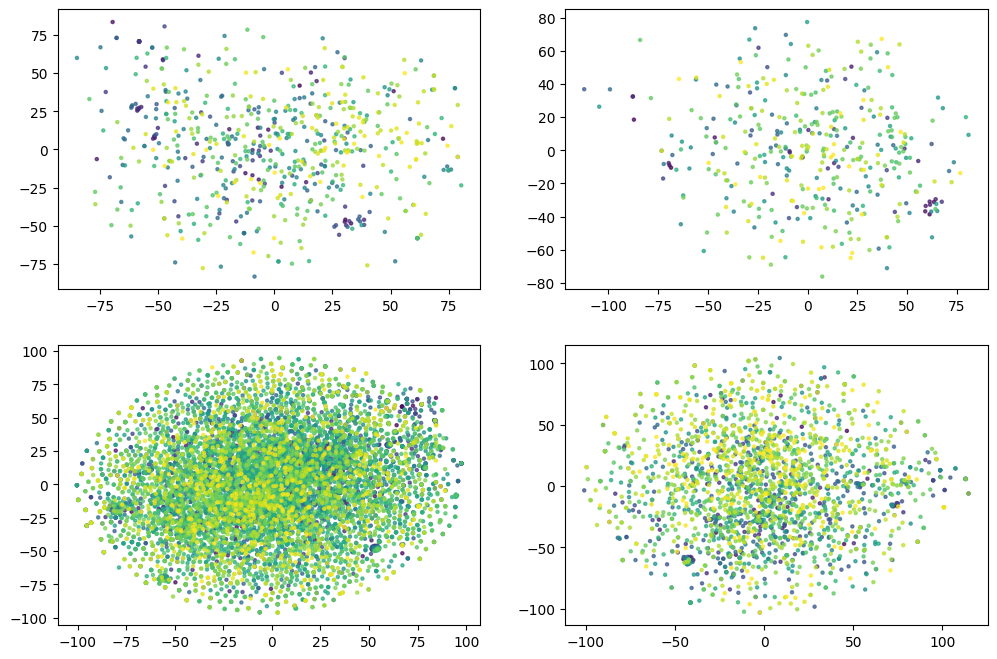

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts[token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, token_counts[token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, token_counts[token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, token_counts[token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

Calculating token frequencies shows that patterns exist in how attention tokens are shared between heads - at least one token is shared between every head pair and at most 4 are shared. This forms a pattern that could point to how heads collaborate under different tasks. This is explored in more detail using random inputs below.

In [10]:
shared_tokens = calculate_shared_tokens(token_counts)
shared_tokens

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,2,"290, 11",2,"290, 11",2,"11, 262",4,"290, 11, 262, 287",3,"11, 198, 262"
1,0.0,2.0,2,"11, 198",2,"290, 11",2,"11, 262",3,"290, 11, 262",4,"290, 11, 198, 262"
2,0.0,3.0,2,"290, 11",1,11,2,"11, 262",3,"290, 11, 262",2,"11, 262"
3,0.0,4.0,1,11,2,"290, 11",3,"11, 198, 262",3,"290, 11, 262",4,"290, 11, 198, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",4,"290, 11, 262, 287",2,"11, 262"
...,...,...,...,...,...,...,...,...,...,...,...,...
10291,140.0,142.0,2,"11, 262",0,,0,,1,27996,0,
10292,140.0,143.0,2,"11, 262",0,,0,,1,44686,0,
10293,141.0,142.0,2,"11, 262",0,,0,,4,"35304, 23785, 21890, 39811",0,
10294,141.0,143.0,2,"11, 262",0,,0,,11,"43177, 1706, 47723, 37579, 48366, 48527, 34704...",1,37226


Below, clockwise from top, are heatmaps for how each pair of heads share attention tokens for the element-wise q*k product, q, k and v components.

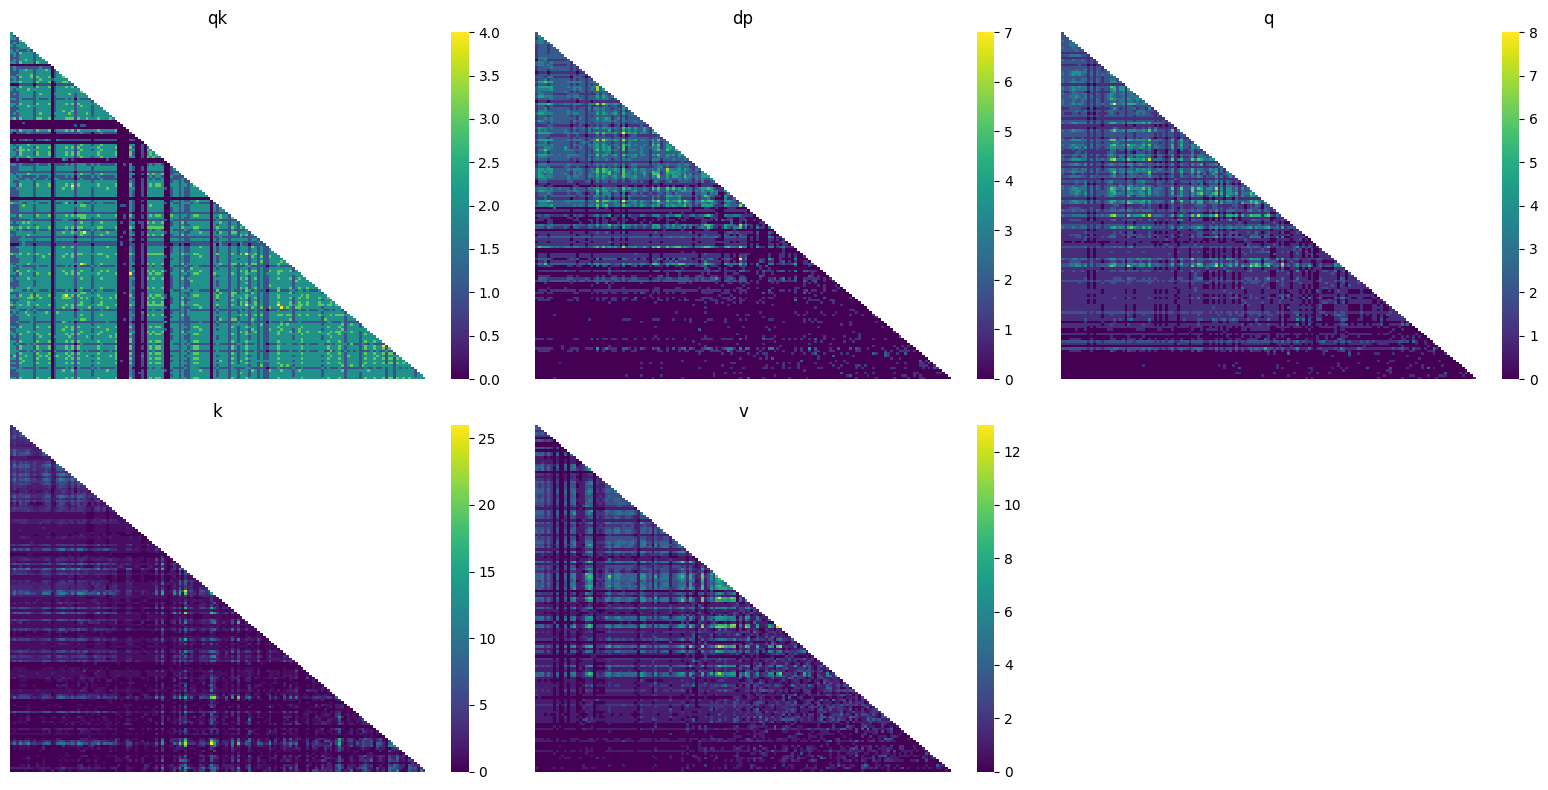

In [11]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(shared_tokens, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Random inputs

Testing with random token inputs provides some insights into how the heads behave in a "default" state. It also makes it easy to change the input length without worrying about being distracted by how that affects the semantic/grammatical structure of the input.

Here are the heads of the first layer using a single random token repeated 30 times.

In [12]:
filename = f'../data/random-single-32.csv'
token = random.randint(0, 50257)
prompt = torch.full((1, 30), token)
prompt = model.to_string(prompt)
random_single_df = load_or_create_data(filename, model, *prompt)
random_single_df

,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
138379,0,26,30,11.0,11.0,32013.0,0.001909,2887.0,47992.0,47698.0,43617.0,2887.0
138380,0,27,30,11.0,11.0,32013.0,0.001874,2887.0,47992.0,47698.0,43617.0,2887.0
138381,0,28,30,11.0,11.0,32013.0,0.001837,2887.0,47992.0,47698.0,43617.0,2887.0
138382,0,29,30,11.0,11.0,32013.0,0.001809,2887.0,47992.0,47698.0,43617.0,2887.0


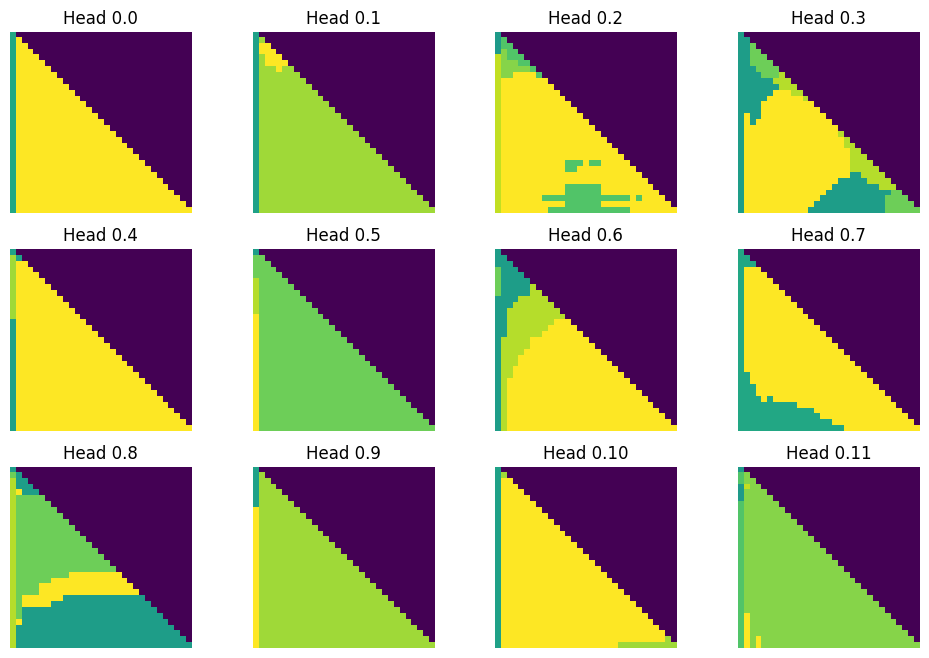

In [13]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    l, h = get_head_index(i)
    attn_data = df_to_tensor(random_single_df, l, h)
    plot_attn(model, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{h}", feature=4)

In [14]:
filename = f'../data/random-full-32.csv'
prompt = torch.randint(0, 50257, (1, 32))
prompt = model.to_string(prompt)
random_full_df = load_or_create_data(filename, model, *prompt)
random_full_df

,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
166459,0,29,33,11.0,11.0,35380.0,0.003046,712.0,76.0,897.0,105.0,68.0
166460,0,30,33,11.0,11.0,35380.0,0.009060,174.0,76.0,897.0,105.0,68.0
166461,0,31,33,11.0,11.0,35380.0,0.006883,712.0,76.0,897.0,105.0,68.0
166462,0,32,33,11.0,11.0,35380.0,0.137795,174.0,143.0,897.0,105.0,68.0


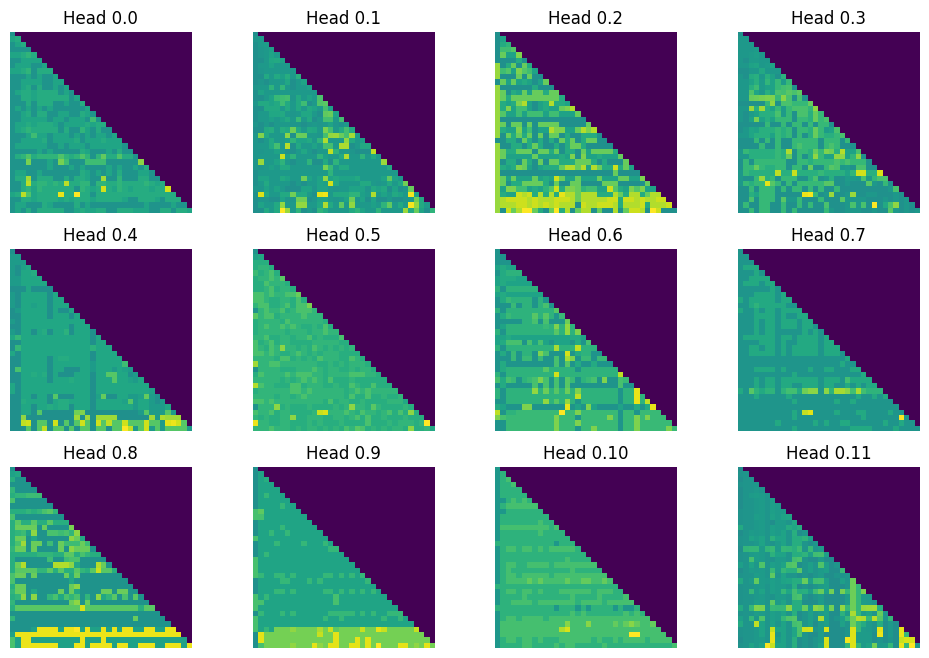

In [15]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    l, h = get_head_index(i)
    attn_data = df_to_tensor(random_full_df, l, h)
    plot_attn(model, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{h}", feature=4)

In [16]:
filename = f'../data/random-seq-32.csv'
prompt = torch.randint(0, 50257, (4, 3)).repeat(1, 10)
prompt = model.to_string(prompt)
random_seq_df = load_or_create_data(filename, model, *prompt)
random_seq_df

,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000e+00,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
553531,3,26,30,11.0,11.0,23844.0,2.117532e-09,44686.0,47992.0,13441.0,12256.0,43617.0
553532,3,27,30,11.0,11.0,23844.0,8.475107e-20,44686.0,47992.0,13441.0,12256.0,43617.0
553533,3,28,30,11.0,11.0,23844.0,6.529128e-17,44686.0,47992.0,13441.0,12256.0,43617.0
553534,3,29,30,11.0,11.0,23844.0,5.265422e-10,44686.0,47992.0,13441.0,12256.0,43617.0


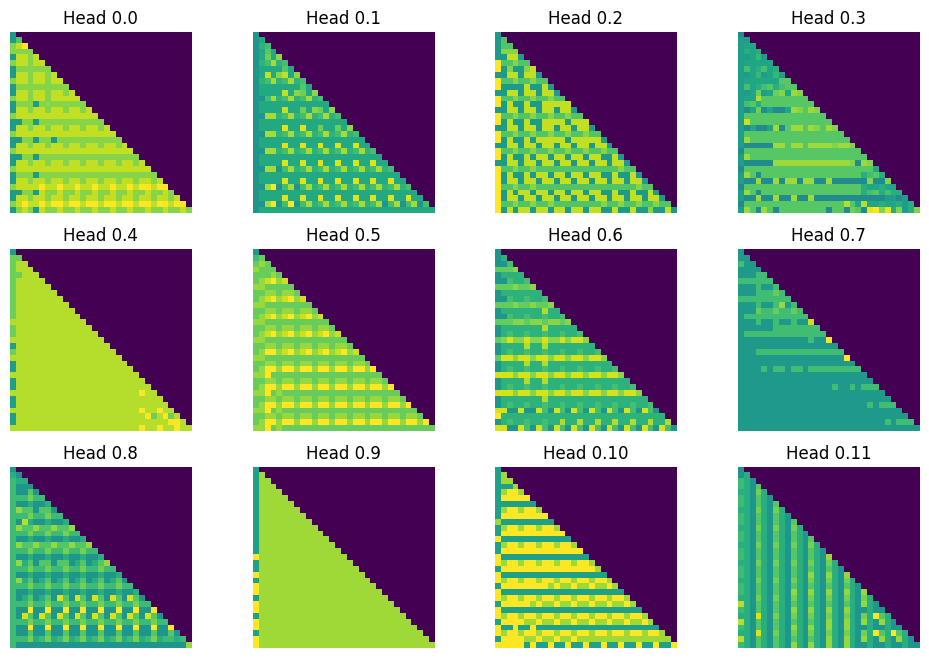

In [17]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    l, h = get_head_index(i)
    attn_data = df_to_tensor(random_seq_df, l, h)
    plot_attn(model, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{h}", feature=4)

While the specific patterns change, if you run this multiple times you can see clear motifs emerge that identify specific heads. You can also see broad similarities in the patterns produced from the same head across inputs.

Again, to get a better idea of how the attention tokens a distributed across heads we can look at the t-SNE plots and shared tokens. The t-SNE plots show similar patterns for the element-wise tokens, but much simpler more structured outputs for q, k and v tokens. This makes sense given the constrained input/output of the random sequence.

In [18]:
token_counts = calculate_token_frequencies(model, random_seq_df)
token_counts

,head_index,token,qk,dp,q,k,v,qk_rank,dp_rank,q_rank,k_rank,v_rank,token str
0,0.0,11,128.0,4.0,1340.0,552.0,175.0,3.0,4.0,1.0,3.0,3.0,","
1,0.0,198,18.0,155.0,0.0,0.0,155.0,7.0,2.0,3.0,6.0,4.0,\n
2,0.0,257,0.0,154.0,0.0,0.0,0.0,10.0,3.0,3.0,6.0,5.0,a
3,0.0,262,0.0,0.0,644.0,612.0,1339.0,10.0,5.0,2.0,2.0,1.0,the
4,0.0,287,0.0,0.0,0.0,790.0,0.0,10.0,5.0,3.0,1.0,5.0,in
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14443,143.0,48808,0.0,0.0,0.0,1.0,0.0,7.0,19.0,30.0,31.0,13.0,Commodore
14444,143.0,48839,0.0,0.0,0.0,12.0,0.0,7.0,19.0,30.0,20.0,13.0,restling
14445,143.0,49268,0.0,0.0,0.0,1.0,0.0,7.0,19.0,30.0,31.0,13.0,Carth
14446,143.0,49288,0.0,0.0,0.0,1.0,0.0,7.0,19.0,30.0,31.0,13.0,edly


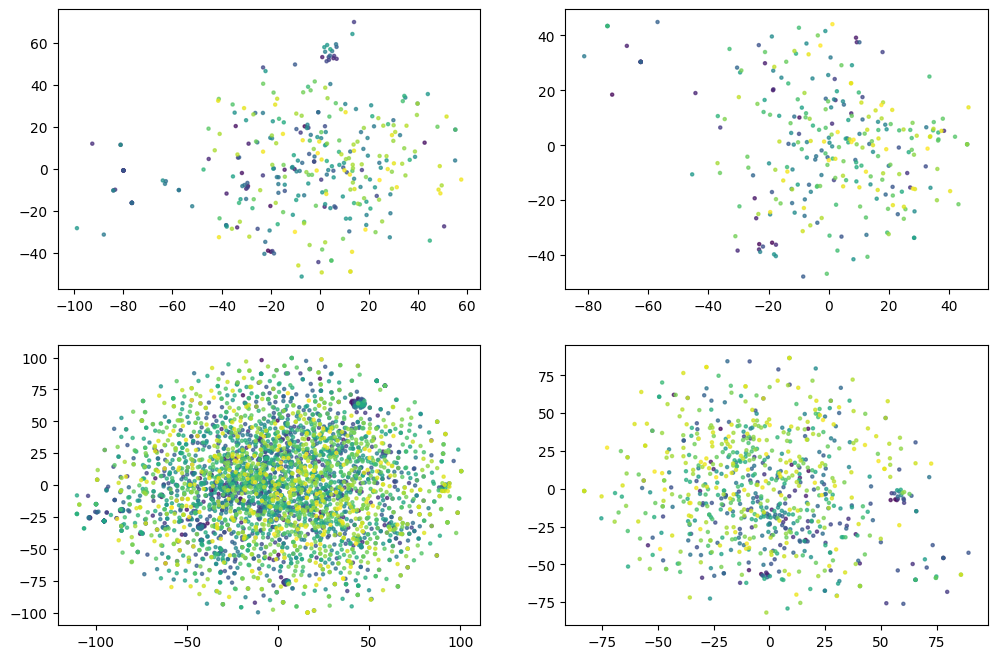

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts[token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, token_counts[token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, token_counts[token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, token_counts[token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

In [20]:
shared_tokens = calculate_shared_tokens(token_counts)
shared_tokens

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,2,"290, 11",2,"11, 198",2,"11, 262",3,"11, 262, 287",3,"290, 11, 262"
1,0.0,2.0,2,"11, 198",3,"290, 11, 198",2,"11, 262",2,"11, 262",3,"290, 198, 262"
2,0.0,3.0,2,"290, 11",2,"11, 198",2,"11, 262",2,"11, 262",2,"11, 262"
3,0.0,4.0,1,11,3,"290, 11, 198",2,"11, 262",2,"11, 262",2,"11, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",3,"11, 262, 287",2,"11, 262"
...,...,...,...,...,...,...,...,...,...,...,...,...
10291,140.0,142.0,1,11,0,,0,,0,,0,
10292,140.0,143.0,1,11,0,,0,,0,,0,
10293,141.0,142.0,2,"11, 262",0,,0,,0,,0,
10294,141.0,143.0,2,"11, 262",0,,0,,1,42036,0,


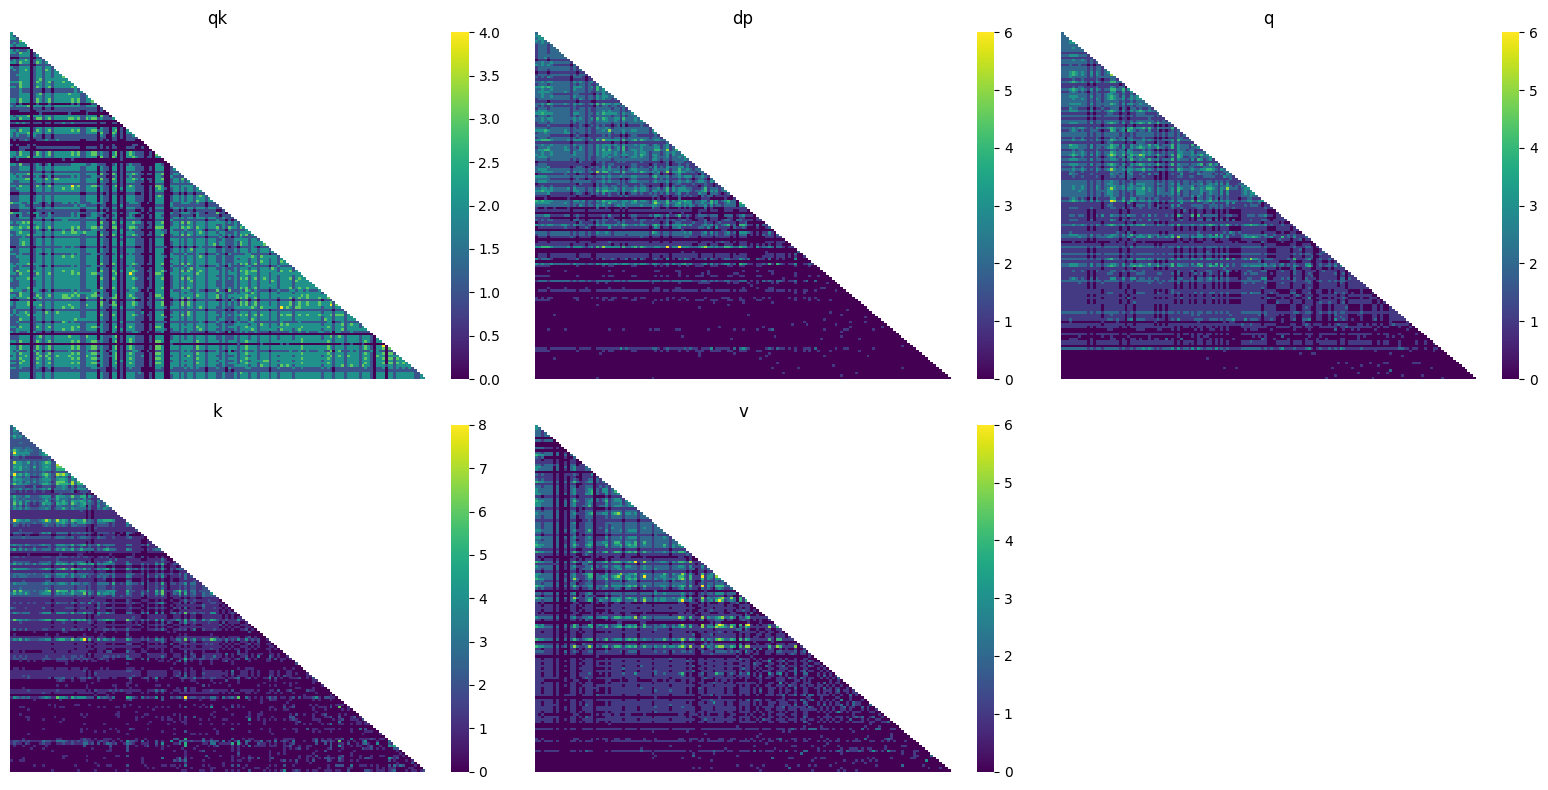

In [21]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(shared_tokens, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

There are a few interesting symmetries that can be observed in how tokens are shared across heads. For example, take head 0.0 and look at all possible pairs with heads of a higher index. If you order by q_count you'll get a maximum of 3 and all the tokens are `"," "\n", " the"`. If you look further down the list you'll see that for pairs that share only 2 or 1 tokens they are always combinations of they three tokens.

In [22]:
p = shared_tokens[shared_tokens['head_index_1'] == 0]
p.sort_values('q_count', ascending=False).head(5)

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,2,"290, 11",2,"11, 198",2,"11, 262",3,"11, 262, 287",3,"290, 11, 262"
79,0.0,80.0,1,11,3,"257, 290, 11",2,"11, 262",1,262,3,"11, 198, 262"
66,0.0,67.0,0,,2,"11, 198",2,"11, 262",2,"11, 262",4,"290, 11, 198, 262"
34,0.0,35.0,2,"11, 198",1,11,2,"11, 262",2,"11, 262",1,11
115,0.0,116.0,1,11,0,,2,"11, 262",0,,1,11


In [23]:
p[p['q_count'] == 2].head(5)

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,2,"290, 11",2,"11, 198",2,"11, 262",3,"11, 262, 287",3,"290, 11, 262"
1,0.0,2.0,2,"11, 198",3,"290, 11, 198",2,"11, 262",2,"11, 262",3,"290, 198, 262"
2,0.0,3.0,2,"290, 11",2,"11, 198",2,"11, 262",2,"11, 262",2,"11, 262"
3,0.0,4.0,1,11,3,"290, 11, 198",2,"11, 262",2,"11, 262",2,"11, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",3,"11, 262, 287",2,"11, 262"


This pattern generally holds, with a few exceptions where pairs certain pairs introduce tokens that are either unique or rarely repeated in the other pairs. You can also see that specific tokens seem very common. Most tokens are from the set that covers all the components - i.e.

In [24]:
q = shared_tokens[['q_shared_tokens']].values
k = shared_tokens[['k_shared_tokens']].values
v = shared_tokens[['v_shared_tokens']].values
qk = shared_tokens[['qk_shared_tokens']].values
dp = shared_tokens[['dp_shared_tokens']].values

qf = [int(num) for sublist in q for item in sublist for num in item.split(', ') if num]
kf = [int(num) for sublist in k for item in sublist for num in item.split(', ') if num]
vf = [int(num) for sublist in v for item in sublist for num in item.split(', ') if num]
qkf = [int(num) for sublist in qk for item in sublist for num in item.split(', ') if num]
dpf = [int(num) for sublist in dp for item in sublist for num in item.split(', ') if num]

all_shared_tokens = list(set(kf))
u = set(qf) & set(kf) & set(vf) & set(qkf) & set(dpf)
len(u), u, [model.to_single_str_token(i) for i in u]

(14,
 {11, 12, 13, 198, 257, 262, 284, 286, 287, 290, 357, 366, 393, 705},
 [' a',
  ' and',
  " '",
  ' (',
  ' the',
  '\n',
  ' or',
  ',',
  '-',
  '.',
  ' "',
  ' to',
  ' of',
  ' in'])

There is a noteable blandness to these tokens, which can probably be attributed to their low index. The tokens are also consistent for different inputs - the above is using random repeating sequences, but if we use the imdb set we get the same set. This points to the positional encodings playing a dominant role in how the tokens are generated and the extra tokens in the imdb set could be explained by the increased complexity of the inputs.

In [25]:
filename = f'../data/imdb.csv'
df = load_or_create_data(filename, model, *prompts)
token_counts_imdb = calculate_token_frequencies(model, df)
shared_tokens_imdb = calculate_shared_tokens(token_counts)

q = shared_tokens_imdb[['q_shared_tokens']].values
k = shared_tokens_imdb[['k_shared_tokens']].values
v = shared_tokens_imdb[['v_shared_tokens']].values
qk = shared_tokens_imdb[['qk_shared_tokens']].values
dp = shared_tokens_imdb[['dp_shared_tokens']].values

qf = [int(num) for sublist in q for item in sublist for num in item.split(', ') if num]
kf = [int(num) for sublist in k for item in sublist for num in item.split(', ') if num]
vf = [int(num) for sublist in v for item in sublist for num in item.split(', ') if num]
qkf = [int(num) for sublist in qk for item in sublist for num in item.split(', ') if num]
dpf = [int(num) for sublist in dp for item in sublist for num in item.split(', ') if num]

all_shared_tokens = list(set(kf))
u = set(qf) & set(kf) & set(vf) & set(qkf) & set(dpf)
len(u), u, [model.to_single_str_token(i) for i in u]

(14,
 {11, 12, 13, 198, 257, 262, 284, 286, 287, 290, 357, 366, 393, 705},
 [' a',
  ' and',
  " '",
  ' (',
  ' the',
  '\n',
  ' or',
  ',',
  '-',
  '.',
  ' "',
  ' to',
  ' of',
  ' in'])

You can see similar behaviour in how the same tokens are used to represent qk across the random and imdb inputs. The individual components (i.e. q, k, v) do have some token overlap, but when combined it's surprising how similar the sets are.

In [26]:
a = set(token_counts[token_counts['qk'] > 0]['token str'].values)
b = set(token_counts_imdb[token_counts_imdb['qk'] > 0]['token str'].values)
c = a & b

len(a), len(b), len(c)

(490, 533, 481)

## Zooming in on subgroups

I have some about how to use attention tokens, and the patterns they form between heads, to uncover model behaviours, but for now I want to focus on the indirect object identification task because it's already well understood. The paper identifies 5 head classes that contribute to completing the correct token: previous token heads, duplicate token heads, induction heads, s-inhibition heads, and name mover heads.

![Head categories](./images/ioi-heads.png)

First, we need to define an input dataset for the IOI task.

In [27]:
from itertools import permutations 

template = "{0} and{1} went to the store.{0} gave the bag to{1}."
names = (" Phil", " Bob", " James", " Paul")

prompts = [
    template.format(S, IO, S, IO)
    for S, IO in permutations(names, 2)
]

len(prompts), prompts[:5]

(12,
 [' Phil and Bob went to the store. Phil gave the bag to Bob.',
  ' Phil and James went to the store. Phil gave the bag to James.',
  ' Phil and Paul went to the store. Phil gave the bag to Paul.',
  ' Bob and Phil went to the store. Bob gave the bag to Phil.',
  ' Bob and James went to the store. Bob gave the bag to James.'])

In [28]:
filename = f'../data/ioi.csv'
ioi_df = load_or_create_data(filename, model, *prompts)
ioi_df

,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
623803,11,14,18,11.0,11.0,3700.0,0.010587,31204.0,47992.0,50183.0,43598.0,2887.0
623804,11,15,18,11.0,11.0,3700.0,0.070426,43407.0,23712.0,50183.0,43598.0,2887.0
623805,11,16,18,11.0,11.0,3700.0,0.122076,2887.0,23712.0,50183.0,43598.0,2887.0
623806,11,17,18,11.0,11.0,3700.0,0.033740,41629.0,23712.0,50183.0,43598.0,2887.0


In [29]:
token_counts = calculate_token_frequencies(model, ioi_df)
token_counts

,head_index,token,qk,dp,q,k,v,qk_rank,dp_rank,q_rank,k_rank,v_rank,token str
0,0.0,11,215.0,12.0,1530.0,504.0,612.0,3.0,4.0,1.0,3.0,2.0,","
1,0.0,198,49.0,0.0,0.0,9.0,360.0,5.0,5.0,3.0,6.0,4.0,\n
2,0.0,262,0.0,0.0,750.0,697.0,732.0,9.0,5.0,2.0,2.0,1.0,the
3,0.0,287,0.0,0.0,0.0,854.0,0.0,9.0,5.0,3.0,1.0,5.0,in
4,0.0,290,0.0,1128.0,0.0,0.0,576.0,9.0,1.0,3.0,7.0,3.0,and
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13506,143.0,48366,0.0,0.0,0.0,114.0,0.0,8.0,22.0,15.0,7.0,10.0,◼
13507,143.0,48765,0.0,0.0,0.0,36.0,0.0,8.0,22.0,15.0,14.0,10.0,recomp
13508,143.0,48839,0.0,0.0,0.0,12.0,0.0,8.0,22.0,15.0,21.0,10.0,restling
13509,143.0,48841,0.0,0.0,0.0,3.0,0.0,8.0,22.0,15.0,27.0,10.0,awar


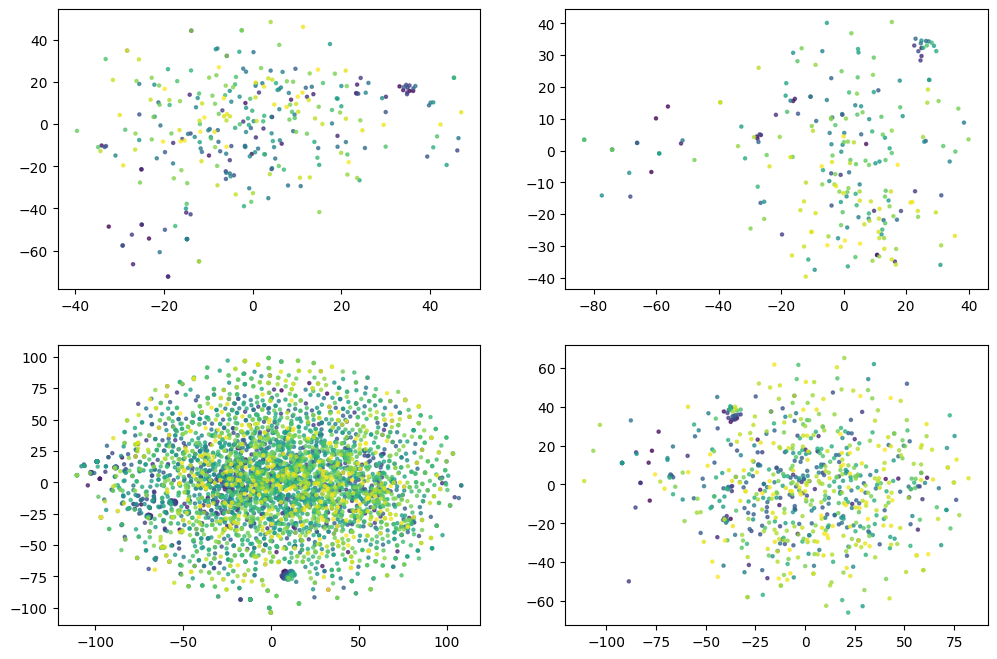

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts[token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, token_counts[token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, token_counts[token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, token_counts[token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

In [31]:
shared_tokens_ioi = calculate_shared_tokens(token_counts)
shared_tokens_ioi

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,1,11,1,11,2,"11, 262",3,"11, 198, 262",3,"11, 198, 262"
1,0.0,2.0,2,"11, 198",2,"290, 11",2,"11, 262",3,"11, 198, 262",3,"290, 11, 262"
2,0.0,3.0,1,11,1,11,2,"11, 262",2,"11, 262",2,"11, 262"
3,0.0,4.0,1,11,2,"290, 11",2,"11, 262",2,"11, 262",2,"11, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",4,"11, 287, 198, 262",2,"11, 262"
...,...,...,...,...,...,...,...,...,...,...,...,...
10291,140.0,142.0,1,11,0,,0,,0,,0,
10292,140.0,143.0,1,11,0,,0,,0,,0,
10293,141.0,142.0,2,"11, 262",0,,0,,1,23785,0,
10294,141.0,143.0,2,"11, 262",0,,0,,3,"44709, 48366, 40119",0,


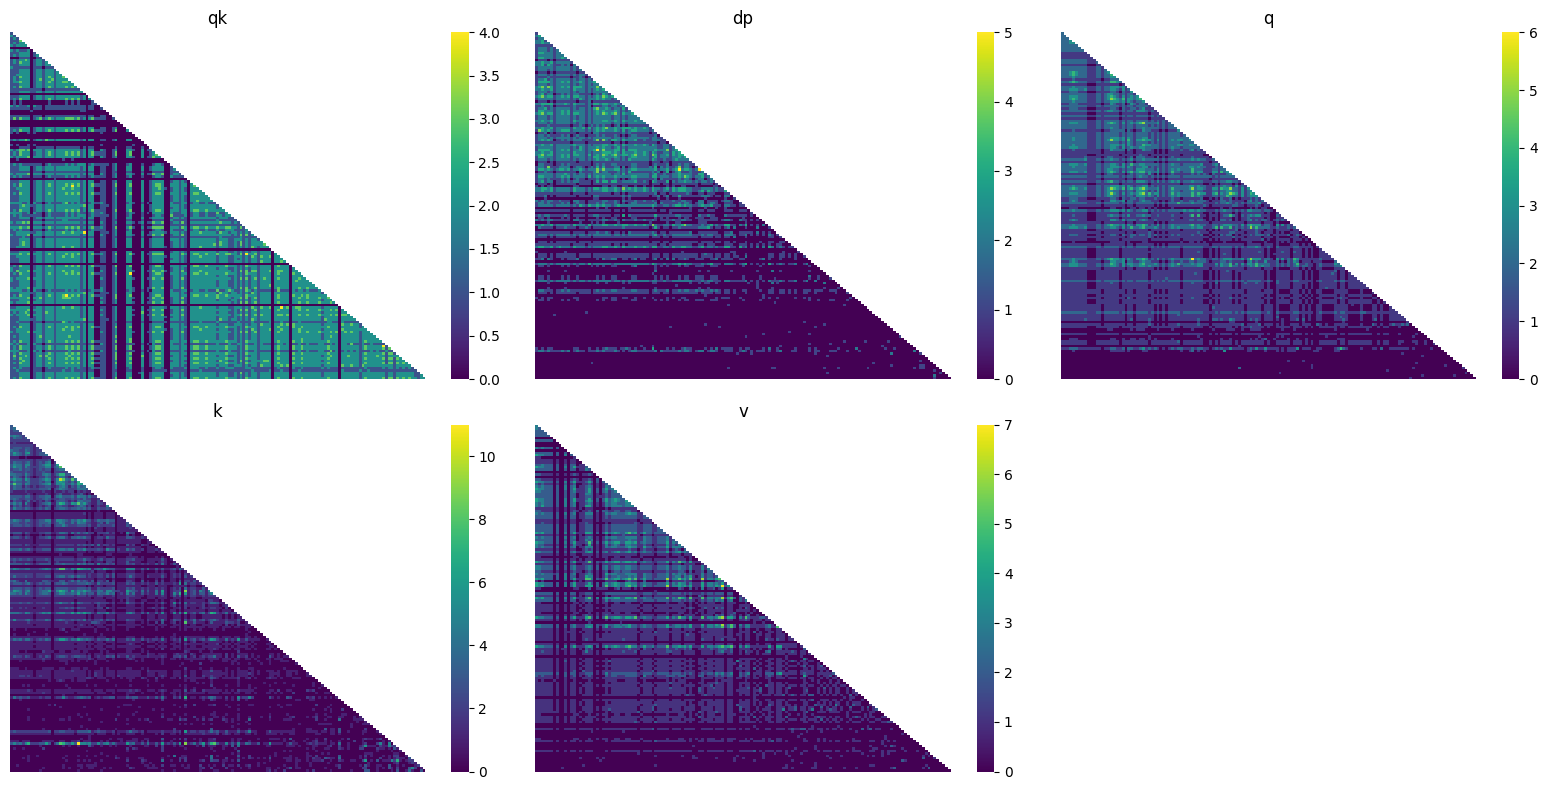

In [32]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(shared_tokens_ioi, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Name mover heads

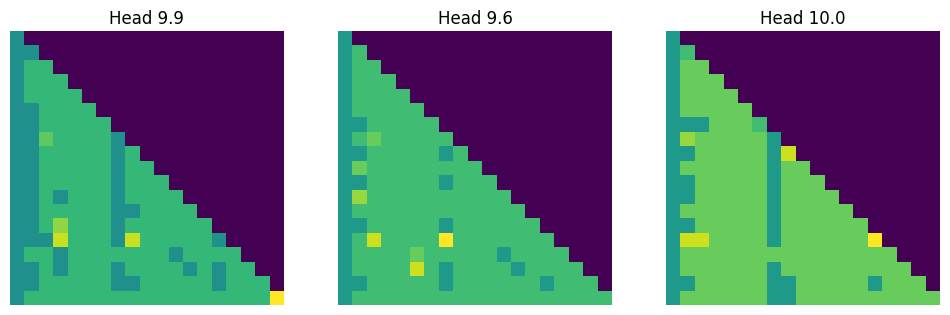

In [33]:
heads = [(9, 9), (9, 6), (10, 0)]
plot, axs = plt.subplots(1, 3, figsize=(12, 8))
for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}", feature=5)

### S-inhibition heads

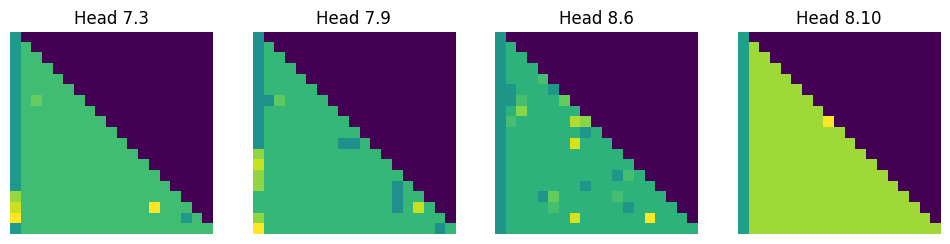

In [34]:
heads = [(7, 3), (7, 9), (8, 6), (8, 10)]
plot, axs = plt.subplots(1, 4, figsize=(12, 8))
for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}", feature=5)

### Duplicate token heads

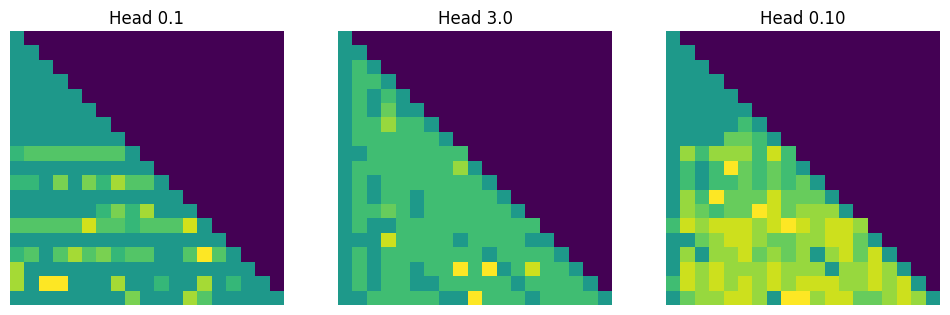

In [35]:
heads = [(0, 1), (3, 0), (0, 10)]
plot, axs = plt.subplots(1, 3, figsize=(12, 8))
for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}", feature=5)

### Induction and previous token heads

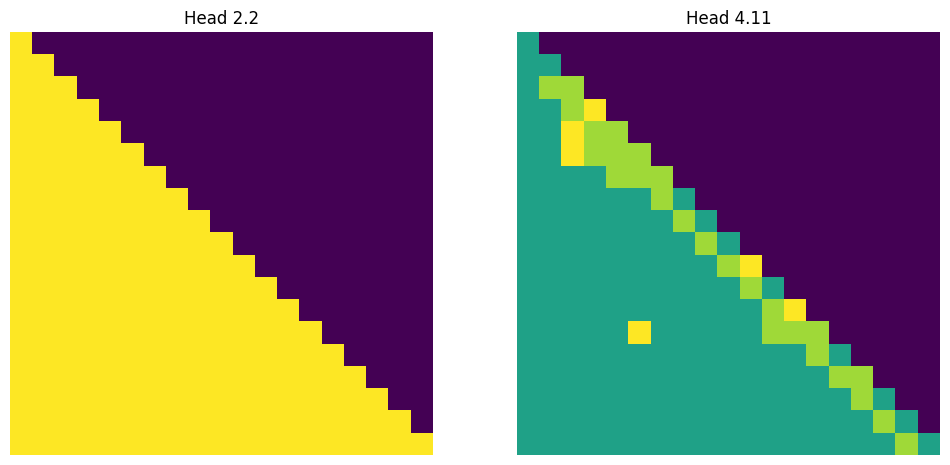

In [36]:
heads = [(2, 2), (4, 11)]
plot, axs = plt.subplots(1, 2, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}", feature=5)

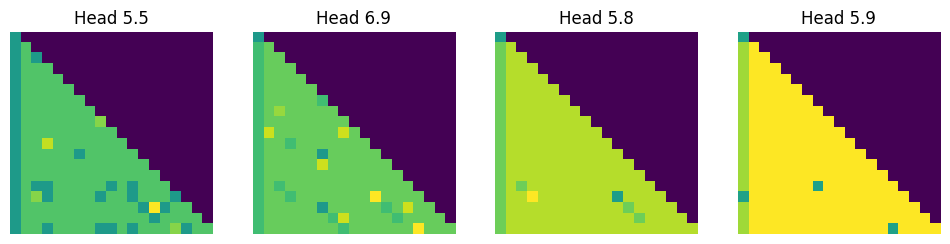

In [37]:
heads = [(5, 5), (6, 9), (5, 8), (5, 9)]
plot, axs = plt.subplots(1, 4, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}", feature=5)

### Negative name-mover heads

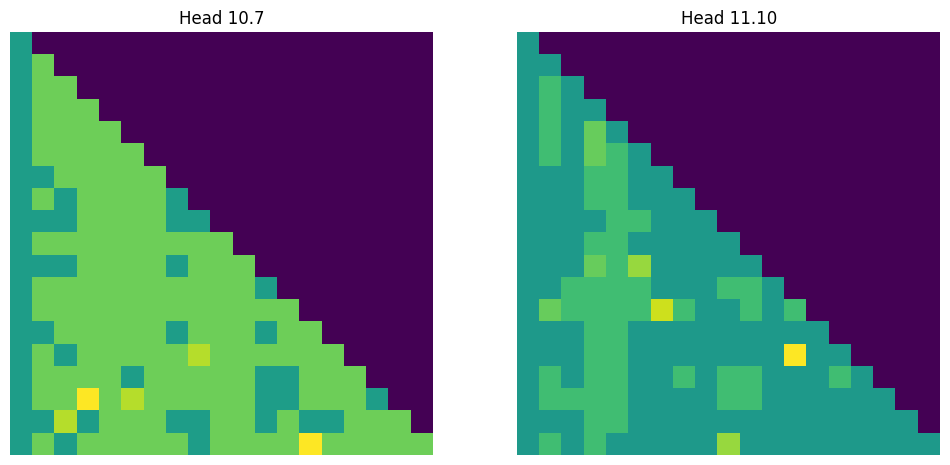

In [38]:
heads = [(10, 7), (11, 10)]
plot, axs = plt.subplots(1, 2, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}", feature=5)

### Backup name-mover heads

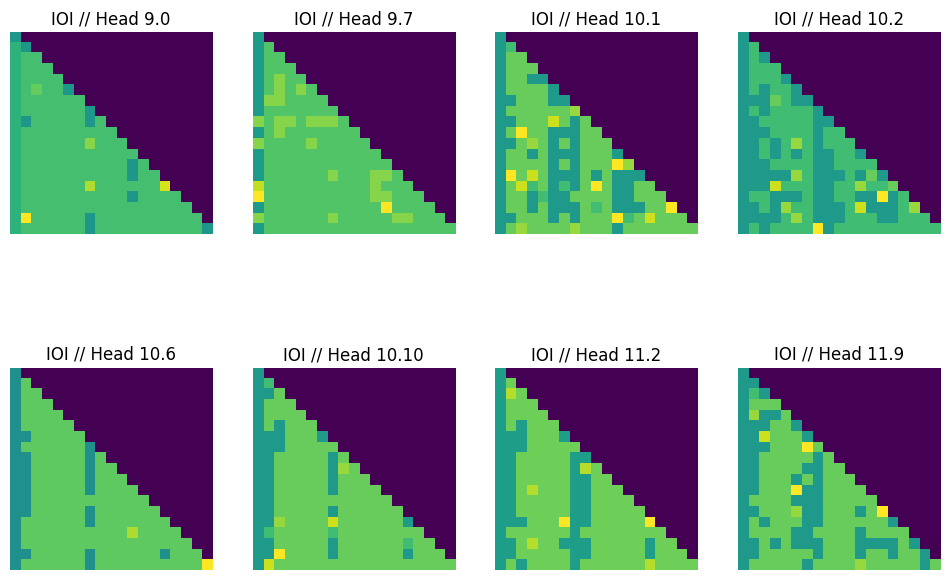

In [39]:
heads = [(9, 0), (9, 7), (10, 1), (10, 2), (10, 6), (10, 10), (11, 2), (11, 9)]
plot, axs = plt.subplots(2, 4, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = df_to_tensor(ioi_df, l, h)
    plot_attn(model, attn_data, ax=axs[i//4, i%4], hide_labels=True, title=f"IOI // Head {l}.{h}", feature=5)